In [1]:
#using vgg 16 pretrained on imagenet data.
from keras.applications import VGG16
img_r = img_c = 224 #input image_size is 224 x 224

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [3]:
import os
os.getcwd()


'/content'

In [4]:
model = VGG16(weights = 'imagenet', include_top = False, input_shape = (img_r, img_c, 3))

for layer in model.layers:
  layer.trainable = False


58892288/58889256 [==============================] - 5s 0us/step


In [5]:
def addCustomLayer(bottom_model, num_classes):
    """creates the head of the model that will bw placed on top of the bottom layers"""
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(512,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model

In [6]:
print("Model info")
n = int(input("Press 1 for input layer name and 2 for all model layers: "))
if(n == 1):
  print(model.input)
else:
  print(model.layers)

Model info
Press 1 for input layer name and 2 for all model layers: 1
Tensor("input_1:0", shape=(None, 224, 224, 3), dtype=float32)


In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

num_classes = 2

FC_Head = addCustomLayer(model, num_classes)

model_new = Model(inputs=model.input, outputs=FC_Head)

print(model_new.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = "/gdrive/My Drive/face_data_train"
validation_dir = "/gdrive/My Drive/face_data_validation" 

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20, 
                                   width_shift_range=0.2, 
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

train_batchsize = 15
val_batchsize = 10

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_r, img_c),
                                                    batch_size=train_batchsize,
                                                    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                    target_size=(img_r, img_c),
                                                    batch_size=val_batchsize,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 120 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [10]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("face_recog_vgg.h5", monitor="val_loss", mode="min", save_best_only = True, verbose=1)
earlystop = EarlyStopping(monitor= 'val_loss', min_delta = 0, patience = 3, verbose = 1, restore_best_weights = True)
callbacks = [earlystop, checkpoint]

model_new.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.001),metrics=['accuracy'])

nb_train_samples=1190
nb_validation_samples=170
epochs=4
batch_size=16

history = model_new.fit_generator(train_generator,
                                 steps_per_epoch=nb_train_samples // batch_size,
                                 epochs=epochs,
                                 callbacks=callbacks,
                                 validation_data=validation_generator,
                                 )
model_new.save("vgg_model_first.h5")

Epoch 1/4
74/74 [==============================] - 75s 1s/step - loss: 0.2147 - accuracy: 0.9279 - val_loss: 1.3804e-05 - val_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 0.00001, saving model to face_recog_vgg.h5
Epoch 2/4
74/74 [==============================] - 19s 263ms/step - loss: 6.9403e-06 - accuracy: 1.0000 - val_loss: 2.8610e-07 - val_accuracy: 1.0000

Epoch 00002: val_loss improved from 0.00001 to 0.00000, saving model to face_recog_vgg.h5
Epoch 3/4
74/74 [==============================] - 20s 266ms/step - loss: 0.1805 - accuracy: 0.9829 - val_loss: 2.6464e-06 - val_accuracy: 1.0000

Epoch 00003: val_loss did not improve from 0.00000
Epoch 4/4
74/74 [==============================] - 20s 270ms/step - loss: 4.3957e-07 - accuracy: 1.0000 - val_loss: 2.5034e-07 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.00000 to 0.00000, saving model to face_recog_vgg.h5


In [11]:
from keras.models import load_model

classifier = load_model('vgg_model_first.h5')


In [15]:
from google.colab.patches import cv2_imshow

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0  29255      0 --:--:-- --:--:-- --:--:-- 29255


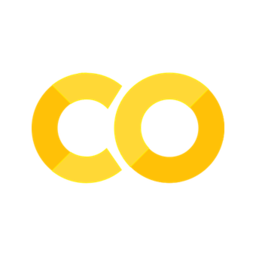

In [16]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
import cv2
img = cv2.imread('logo.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

Class - Pranav


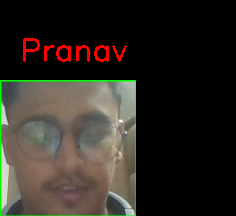

Class - Vineeth


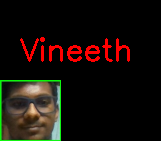

Class - Vineeth


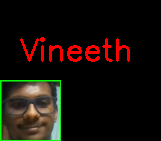

Class - Pranav


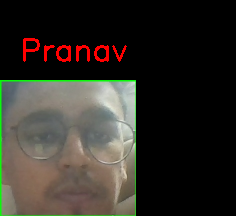

Class - Pranav


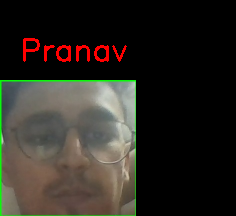

Class - Vineeth


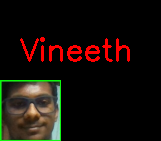

Class - Vineeth


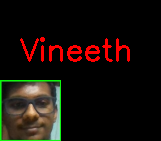

Class - Pranav


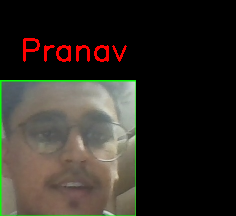

Class - Vineeth


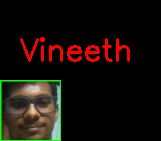

Class - Vineeth


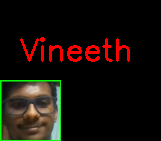

In [21]:
import os
import cv2
import numpy as np
from os import listdir
from os.path import isfile, join

fr_dict = {"[0]": "Pranav", 
                      "[1]": "Vineeth",
                      }

fr_dict_n = {"vineeth": "Vineeth", 
                      "pranav": "Pranav",
                      }

def draw_test(name, pred, im):
    face = fr_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im, 80, 0, 0, 100 ,cv2.BORDER_CONSTANT,value=BLACK)
    cv2.putText(expanded_image, face, (20, 60) , cv2.FONT_HERSHEY_SIMPLEX,1, (0,0,255), 2)
    cv2_imshow(expanded_image)

def getRandomImage(path):
    """function loads a random images from a random folder in our test path """
    folders = list(filter(lambda x: os.path.isdir(os.path.join(path, x)), os.listdir(path)))
    random_directory = np.random.randint(0,len(folders))
    path_class = folders[random_directory]
    print("Class - " + fr_dict_n[str(path_class)])
    file_path = path + path_class
    file_names = [f for f in listdir(file_path) if isfile(join(file_path, f))]
    random_file_index = np.random.randint(0,len(file_names))
    image_name = file_names[random_file_index]
    return cv2.imread(file_path+"/"+image_name)    

for i in range(0,10):
    input_im = getRandomImage("/gdrive/My Drive/face_data_validation/")
    input_original = input_im.copy()
    input_original = cv2.resize(input_original, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_LINEAR)
    
    input_im = cv2.resize(input_im, (224, 224), interpolation = cv2.INTER_LINEAR)
    input_im = input_im / 255.
    input_im = input_im.reshape(1,224,224,3) 
    
    # Get Prediction
    res = np.argmax(classifier.predict(input_im, 1, verbose = 0), axis=1)
    
    # Show image with predicted class
    draw_test("Prediction", res, input_original) 
    cv2.waitKey(0)

cv2.destroyAllWindows()